In [78]:
import numpy as np
import os
import matplotlib.pyplot as plt
import nibabel as nib
from medpy.metric.binary import dc
from tqdm import tqdm
from numpy import genfromtxt
import pandas as pd

# The Model we use

In [3]:
loss = genfromtxt('loss.csv', delimiter=',')

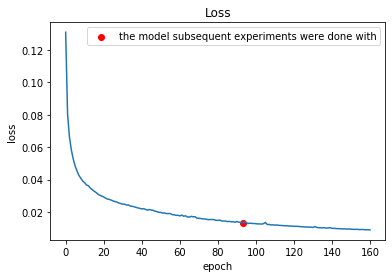

In [4]:
plt.plot(loss[1:,1])
plt.scatter(93,loss[93,1], c='r', label = 'the model subsequent experiments were done with')
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [5]:
gt_base_path = 'Silver-standard-ML/'
pred_base_path = 'SkolBrainet/predictions/'

In [7]:
path = pred_base_path + os.listdir(pred_base_path)[1]  
test = np.load(path)

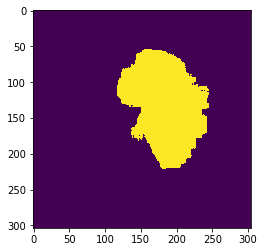

In [8]:
plt.imshow(test[100,:,:])

# Dice scores

In [14]:
pred = {}
for name in os.listdir(pred_base_path):
    scan_N = int(name.split('_')[2][2:])
    path = pred_base_path + name  
    file = np.load(path)
    pred[scan_N] = file

In [33]:
gt = {}
crop_size = 65
padding = crop_size // 2
pad = ((padding, padding), (padding, padding), (padding, padding))
imgsPredicted = list(pred.keys())
for name in tqdm(os.listdir(gt_base_path)):
    scan_N = int(name.split('_')[0][2:])
    if scan_N in imgsPredicted:
        path = gt_base_path + name  
        img = nib.load(path)
        data = img.get_fdata()
        padded_gt = np.pad(data, pad)
        gt[scan_N] = padded_gt

100%|██████████| 359/359 [00:29<00:00, 12.38it/s]


In [38]:
dices = {}

In [39]:
for N in tqdm(imgsPredicted):
    dices[N] = dc(pred[N],gt[N])

100%|██████████| 236/236 [00:11<00:00, 21.41it/s]


In [64]:
dicesForDomains = {}
for name in os.listdir(pred_base_path):
    domain = name.split('_')[3] + name.split('_')[4]
    scan_N = int(name.split('_')[2][2:])
    if domain == 'siemens15':
        if scan_N >= 120 and scan_N <= 169:
            domain = domain +'_train'
        else:
            domain = domain +'_rest_of_the_domain'
    if domain in dicesForDomains.keys():
        dicesForDomains[domain].append([scan_N, dices[scan_N]])
    else:
        dicesForDomains[domain] = [[scan_N, dices[scan_N]]]

In [66]:
for key in dicesForDomains.keys():
    print(key, ':', len(dicesForDomains[key]), 'scans') 

ge3 : 60 scans
philips3 : 55 scans
ge15 : 60 scans
siemens15_train : 50 scans
siemens15_rest_of_the_domain : 10 scans
philips15 : 1 scans


In [111]:
domains_list = ['siemens15_train', 'siemens15_rest_of_the_domain','philips15', 'ge15', 'philips3', 'ge3']
avg_arr = []
std_arr = []
number_scans = []

for key in domains_list: 
    avg = np.array(dicesForDomains[key])[:,1].mean()
    std = np.array(dicesForDomains[key])[:,1].std()
    print(key, ':', len(dicesForDomains[key]), 'scans; dice = ', round(avg,3), '+-', round(std,3)) 
    
    avg_arr.append(round(avg,3))
    std_arr.append(round(std,3))
    number_scans.append(len(dicesForDomains[key]))

siemens15_train : 50 scans; dice =  0.973 +- 0.004
siemens15_rest_of_the_domain : 10 scans; dice =  0.973 +- 0.003
philips15 : 1 scans; dice =  0.962 +- 0.0
ge15 : 60 scans; dice =  0.955 +- 0.011
philips3 : 55 scans; dice =  0.95 +- 0.02
ge3 : 60 scans; dice =  0.947 +- 0.033


In [112]:
a = pd.DataFrame(np.array([avg_arr, std_arr, number_scans]),
                   columns=domains_list)
a = a.T
a.columns = ['dice','std','number_of_scans']
a.number_of_scans = a.number_of_scans.astype(int)

In [113]:
a

,dice,std,number_of_scans
siemens15_train,0.973,0.004,50
siemens15_rest_of_the_domain,0.973,0.003,10
philips15,0.962,0.000,1
ge15,0.955,0.011,60
philips3,0.950,0.020,55
ge3,0.947,0.033,60
